In [37]:
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("Datasets-with-cloud/amman_Ready.csv")

# API

In [63]:
import openmeteo_requests
import requests_cache
import pandas as pd
import numpy as np
import datetime as dt
import pytz
from retry_requests import retry
from metpy.calc import wind_components
from metpy.units import units

In [69]:
# Function to extract ordered hourly variables 
def get_ordered_hourly_variables(params):
    return params.get("hourly", [])

# Set up API client with caching and retries
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)


def get_reading(url, latitude, longtitute, hourly, past_days, future_days):
  params = {
    "latitude": latitude,
    "longitude": longtitute,
    "hourly": hourly,
    "past_days": past_days,
    "forecast_days": future_days
  }

  response = openmeteo.weather_api(url, params=params)[0]
  hourly = response.Hourly()
  hourly_data = {
    "date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    )
  }
  for i, var_name in enumerate(get_ordered_hourly_variables(params)):
    hourly_data[var_name] = hourly.Variables(i).ValuesAsNumpy()

  #Modify df
  hourly_df = pd.DataFrame(data=hourly_data)
  hourly_df['Date/Time'] = pd.to_datetime(hourly_df['date'], errors='coerce')
  hourly_df.set_index('Date/Time', inplace=True)
  hourly_df.drop(columns=['date'], inplace = True)

  return hourly_df

# Random forest classifier with gradient boosting regression

In [3]:
df = pd.read_csv("Datasets-with-cloud/amman_Ready.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210384 entries, 0 to 210383
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            210384 non-null  object 
 1   Air Dew Point         210384 non-null  float64
 2   Air Temperature (OC)  210384 non-null  float64
 3   Humidity %            210384 non-null  float64
 4   Atmospheric Pressure  210384 non-null  float64
 5   Cloud Cover %         210384 non-null  float64
 6   Wind_U                210384 non-null  float64
 7   Wind_V                210384 non-null  float64
dtypes: float64(7), object(1)
memory usage: 12.8+ MB


In [4]:
df['Cloud Cover %'].unique()

array([  0.  ,  12.5 ,   8.33,  16.67,  25.  ,  45.83,  66.67,  87.5 ,
        62.5 ,  83.33,  37.5 ,  58.33,  29.17,  20.83,  95.83,  75.  ,
        50.  , 100.  ,  91.67,  33.33,  79.17,   4.17,  70.83,  54.17,
        41.67])

In [118]:
df['Cloud Cover %'] = df['Cloud Cover %'].rolling(window=3, center=True).mean()

In [119]:
df['time'] = pd.to_datetime(df['Unnamed: 0'])
df = df[df['time'].dt.year >= 2005].reset_index(drop=True)
# Feature engineering
df['hour'] = df['time'].dt.hour
df['dayofweek'] = df['time'].dt.dayofweek
df['month'] = df['time'].dt.month

# Rolling averages (you can tune this)
for col in ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %', 
            'Atmospheric Pressure', 'Wind_U', 'Wind_V']:
    df[f'{col}_roll3'] = df[col].rolling(window=3, min_periods=1).mean()

# Binary target for classification
df['has_cloud'] = (df['Cloud Cover %'] > 0).astype(int)

# Drop unused columns
df = df.drop(columns=['Unnamed: 0', 'time'])

# === 2. Prepare features ===
features = [col for col in df.columns if col not in ['Cloud Cover %', 'has_cloud']]
X = df[features]
y_cls = df['has_cloud']
y_reg = df['Cloud Cover %']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 3. Split data chronologically (time series split recommended) ===
split_idx = int(len(df) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_cls_train, y_cls_test = y_cls[:split_idx], y_cls[split_idx:]
y_reg_train, y_reg_test = y_reg[:split_idx], y_reg[split_idx:]



In [120]:
# === 4. Step 1: Classification ===
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_cls_train)
cls_preds = clf.predict(X_test)

print("\n--- Classification Report ---")
print(classification_report(y_cls_test, cls_preds))

# === 5. Step 2: Regression only for rows with cloud cover > 0 ===
mask_train = y_cls_train == 1
mask_test = y_cls_test == 1

reg = GradientBoostingRegressor()
reg.fit(X_train[mask_train], y_reg_train[mask_train])
reg_preds = reg.predict(X_test[mask_test])

print("\n--- Regression Metrics ---")
print("MAE:", mean_absolute_error(y_reg_test[mask_test], reg_preds))
print("RMSE:", mean_squared_error(y_reg_test[mask_test], reg_preds))


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.74      0.76      0.75     17816
           1       0.71      0.69      0.70     15492

    accuracy                           0.73     33308
   macro avg       0.73      0.73      0.73     33308
weighted avg       0.73      0.73      0.73     33308


--- Regression Metrics ---
MAE: 12.7052275545269
RMSE: 240.0125387485204


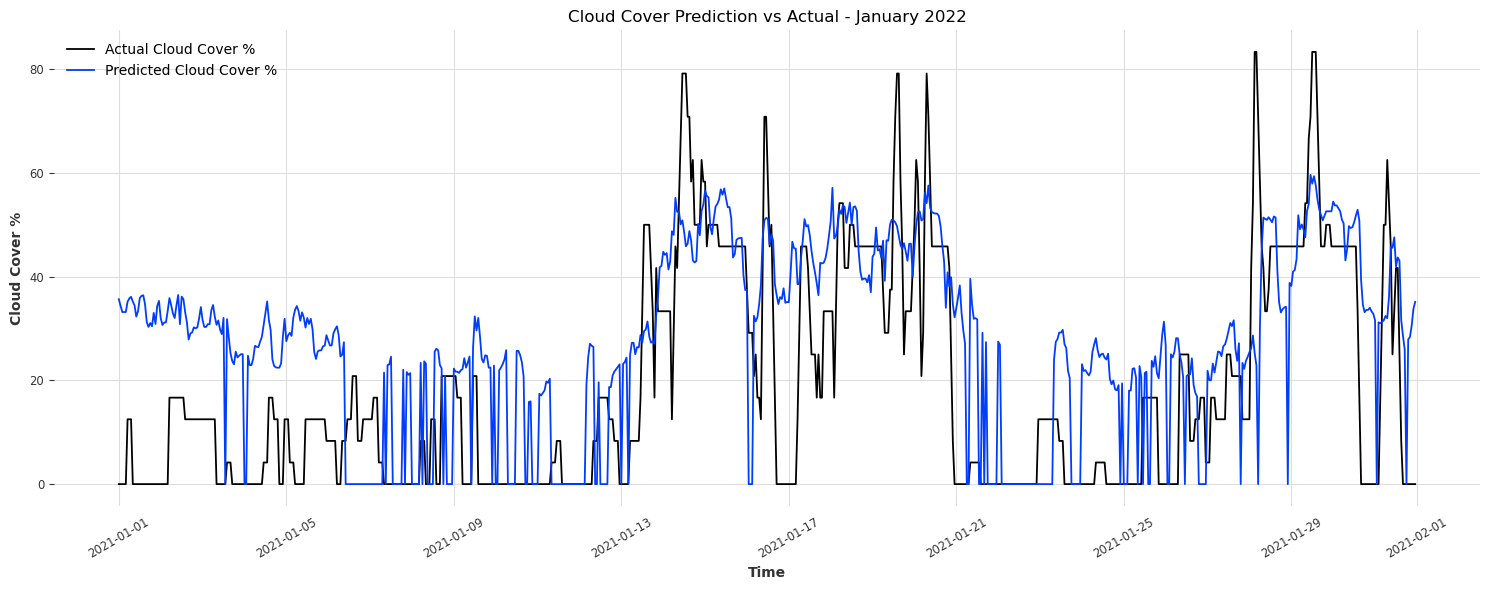


--- January 2022 Metrics ---
MAE: 14.86
RMSE: 351.37


In [123]:
df = pd.read_csv("Datasets-with-cloud/amman_Ready.csv")
df['time'] = pd.to_datetime(df['Unnamed: 0'])
df['hour'] = df['time'].dt.hour
df['dayofweek'] = df['time'].dt.dayofweek
df['month'] = df['time'].dt.month
df['year'] = df['time'].dt.year

for col in ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
            'Atmospheric Pressure', 'Wind_U', 'Wind_V']:
    df[f'{col}_roll3'] = df[col].rolling(window=3, min_periods=1).mean()

df['has_cloud'] = (df['Cloud Cover %'] > 0).astype(int)

# Recompute features
features = [col for col in df.columns if col not in ['Unnamed: 0', 'time', 'Cloud Cover %', 'has_cloud', 'year']]
X_all = df[features]
X_all_scaled = scaler.transform(X_all)

# Create test set (e.g., last 20%)
split_idx = int(len(df) * 0.8)
X_test = X_all_scaled[split_idx:]
y_cls_test = df['has_cloud'].iloc[split_idx:].reset_index(drop=True)
y_reg_test = df['Cloud Cover %'].iloc[split_idx:].reset_index(drop=True)
df_test = df.iloc[split_idx:].reset_index(drop=True)

# --- Prediction ---
cls_preds = clf.predict(X_test)
mask_test = cls_preds == 1
reg_preds = np.zeros_like(y_reg_test)
reg_preds[mask_test] = reg.predict(X_test[mask_test])

df_test['predicted_cloud'] = reg_preds
df_test['actual_cloud'] = y_reg_test
df_test['predicted_has_cloud'] = cls_preds

# --- Filter January 2022 ---
jan2022 = df_test[(df_test['time'].dt.year == 2021) & (df_test['time'].dt.month == 1)]

# --- Plot ---
plt.figure(figsize=(15, 6))
sns.lineplot(data=jan2022, x='time', y='actual_cloud', label='Actual Cloud Cover %')
sns.lineplot(data=jan2022, x='time', y='predicted_cloud', label='Predicted Cloud Cover %')
plt.title("Cloud Cover Prediction vs Actual - January 2022")
plt.ylabel("Cloud Cover %")
plt.xlabel("Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# --- Metrics ---
print("\n--- January 2022 Metrics ---")
mae = mean_absolute_error(jan2022['actual_cloud'], jan2022['predicted_cloud'])
rmse = mean_squared_error(jan2022['actual_cloud'], jan2022['predicted_cloud'])
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Model 5

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import requests_cache
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from metpy.calc import wind_components
from metpy.units import units
from openmeteo_requests import Client
from retry_requests import retry
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam


In [77]:
df = pd.read_csv("Datasets-with-cloud/amman_Ready.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210384 entries, 0 to 210383
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            210384 non-null  object 
 1   Air Dew Point         210384 non-null  float64
 2   Air Temperature (OC)  210384 non-null  float64
 3   Humidity %            210384 non-null  float64
 4   Atmospheric Pressure  210384 non-null  float64
 5   Cloud Cover %         210384 non-null  float64
 6   Wind_U                210384 non-null  float64
 7   Wind_V                210384 non-null  float64
dtypes: float64(7), object(1)
memory usage: 12.8+ MB


In [78]:
df = pd.read_csv("Datasets-with-cloud/amman_Ready.csv")
df['time'] = pd.to_datetime(df['Unnamed: 0'])
df.drop(columns=['Unnamed: 0'], inplace=True)

# Extract datetime features
df['hour'] = df['time'].dt.hour
df['month'] = df['time'].dt.month

# Cyclical encoding for time
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)


# Final input and output
input_features = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
                  'Atmospheric Pressure', 'Wind_U', 'Wind_V']
target_feature = 'Cloud Cover %'

# Train/validation/test split
split_point = int(len(df) * 0.875)
dl_train = df.iloc[:split_point].copy()
dl_val = df.iloc[split_point: split_point + 4320].copy()
dl_test = df.iloc[split_point + 4320:].copy()

In [79]:
# Scale input features
input_scaler = RobustScaler()
input_scaler.fit(dl_train[input_features])
dl_train[input_features] = input_scaler.transform(dl_train[input_features])
dl_val[input_features] = input_scaler.transform(dl_val[input_features])
dl_test[input_features] = input_scaler.transform(dl_test[input_features])

# Scale target separately if needed for loss optimization
target_scaler = RobustScaler()
target_scaler.fit(dl_train[[target_feature]])
dl_train[target_feature] = target_scaler.transform(dl_train[[target_feature]])
dl_val[target_feature] = target_scaler.transform(dl_val[[target_feature]])
dl_test[target_feature] = target_scaler.transform(dl_test[[target_feature]])

# Save scalers
joblib.dump(input_scaler, 'scaler_inputs.save')
joblib.dump(target_scaler, 'scaler_target.save')

['scaler_target.save']

In [80]:
def df_to_X_y(df_X, df_y, window_size=14):
    X, y = [], []
    for i in range(len(df_X) - window_size):
        X.append(df_X.iloc[i:i+window_size].values)
        y.append(df_y.iloc[i + window_size].values)
    return np.array(X), np.array(y)

X_train, y_train = df_to_X_y(dl_train[input_features], dl_train[[target_feature]])
X_val, y_val = df_to_X_y(dl_val[input_features], dl_val[[target_feature]])
X_test, y_test = df_to_X_y(dl_test[input_features], dl_test[[target_feature]])

In [82]:
model = Sequential([
    InputLayer(input_shape=(14, 6)),
    LSTM(64, return_sequences=True),
    LSTM(128),
    Dense(64, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(0.0001), loss=MeanSquaredError(), metrics=['mse'])

cp = ModelCheckpoint('cloud_model.keras', save_best_only=True)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])


C:\Users\abood\miniconda3\envs\ml-env\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 170s 29ms/step - loss: 0.4703 - mse: 0.4703 - val_loss: 0.3438 - val_mse: 0.3438
Epoch 2/10
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 162s 28ms/step - loss: 0.4243 - mse: 0.4243 - val_loss: 0.3347 - val_mse: 0.3347
Epoch 3/10
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 227s 32ms/step - loss: 0.4109 - mse: 0.4109 - val_loss: 0.3354 - val_mse: 0.3354
Epoch 4/10
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 195s 31ms/step - loss: 0.4020 - mse: 0.4020 - val_loss: 0.3398 - val_mse: 0.3398
Epoch 5/10
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 211s 33ms/step - loss: 0.3951 - mse: 0.3951 - val_loss: 0.3458 - val_mse: 0.3458
Epoch 6/10
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 203s 33ms/step - loss: 0.3894 - mse: 0.3894 - val_loss: 0.3265 - val_mse: 0.3265
Epoch 7/10
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 200s 33ms/step - loss: 0.3816 - mse: 0.3816 - val_loss: 0.3376 - val_mse: 0.3376
Epoch 8/10
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 205s 33ms/step - loss: 0.3776 - mse: 0.3776 - val_loss: 0.3617 - val_mse: 0.3617
Epoch 9/10
5753/

687/687 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step


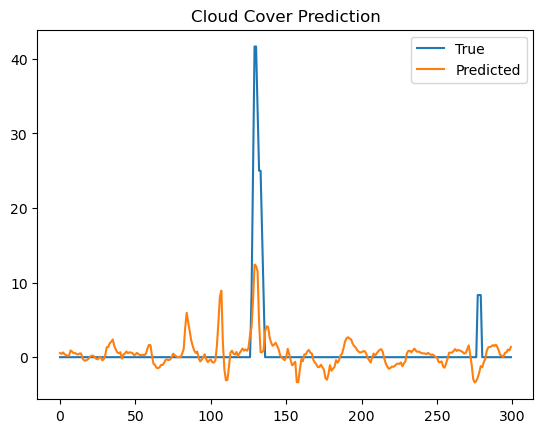

MAE: 9.07875040033918
RMSE: 13.144718808676187
R²: 0.4826554113667637


In [83]:
y_test_pred = model.predict(X_test)
y_test_true = target_scaler.inverse_transform(y_test)
y_test_pred = target_scaler.inverse_transform(y_test_pred)

# Plot
plt.plot(y_test_true[:300], label='True')
plt.plot(y_test_pred[:300], label='Predicted')
plt.title("Cloud Cover Prediction")
plt.legend()
plt.show()

# Metrics
print(f"MAE: {mean_absolute_error(y_test_true, y_test_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_true, y_test_pred))}")
print(f"R²: {r2_score(y_test_true, y_test_pred)}")

In [84]:
def get_forecast_data():
    url = "https://api.open-meteo.com/v1/forecast"
    hourly_vars = [
        "temperature_2m", "wind_speed_10m", "wind_direction_10m",
        "relative_humidity_2m", "dew_point_2m", "pressure_msl"
    ]

    cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    client = Client(session=retry_session)

    params = {
        "latitude": 31.95,
        "longitude": 35.91,
        "hourly": hourly_vars,
        "forecast_days": 2
    }

    response = client.weather_api(url, params=params)[0]
    hourly = response.Hourly()
    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        )
    }

    for i, var in enumerate(hourly_vars):
        hourly_data[var] = hourly.Variables(i).ValuesAsNumpy()

    df = pd.DataFrame(hourly_data)
    df['Date/Time'] = pd.to_datetime(df['date']).dt.tz_convert('Asia/Amman')
    df.set_index('Date/Time', inplace=True)
    df.drop(columns=['date'], inplace=True)

    # Wind conversion
    wind_speed_mps = df['wind_speed_10m'] / 3.6
    u, v = wind_components(
        wind_speed_mps.values * units('m/s'),
        df['wind_direction_10m'].values * units.degree
    )

    df['Wind_U'] = u.magnitude
    df['Wind_V'] = v.magnitude

    # Rename for input
    df = df.rename(columns={
        'dew_point_2m': 'Air Dew Point',
        'temperature_2m': 'Air Temperature (OC)',
        'relative_humidity_2m': 'Humidity %',
        'pressure_msl': 'Atmospheric Pressure'
    })

    return df[[col for col in input_features]].dropna()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 448ms/step


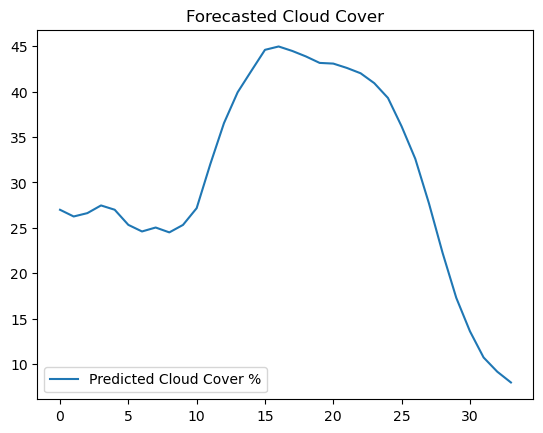

In [85]:
model = tf.keras.models.load_model('cloud_model.keras')
input_scaler = joblib.load('scaler_inputs.save')
target_scaler = joblib.load('scaler_target.save')

# Get and prepare forecast
forecast_df = get_forecast_data()
forecast_df[input_features] = input_scaler.transform(forecast_df[input_features])

# Create sequences for prediction
def create_forecast_sequences(df, window_size=14):
    sequences = []
    for i in range(len(df) - window_size):
        sequences.append(df.iloc[i:i+window_size].values)
    return np.array(sequences)

X_forecast = create_forecast_sequences(forecast_df)

# Predict
forecast_preds_scaled = model.predict(X_forecast)
forecast_preds = target_scaler.inverse_transform(forecast_preds_scaled)

# Plot
plt.plot(forecast_preds, label='Predicted Cloud Cover %')
plt.title("Forecasted Cloud Cover")
plt.legend()
plt.show()

135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


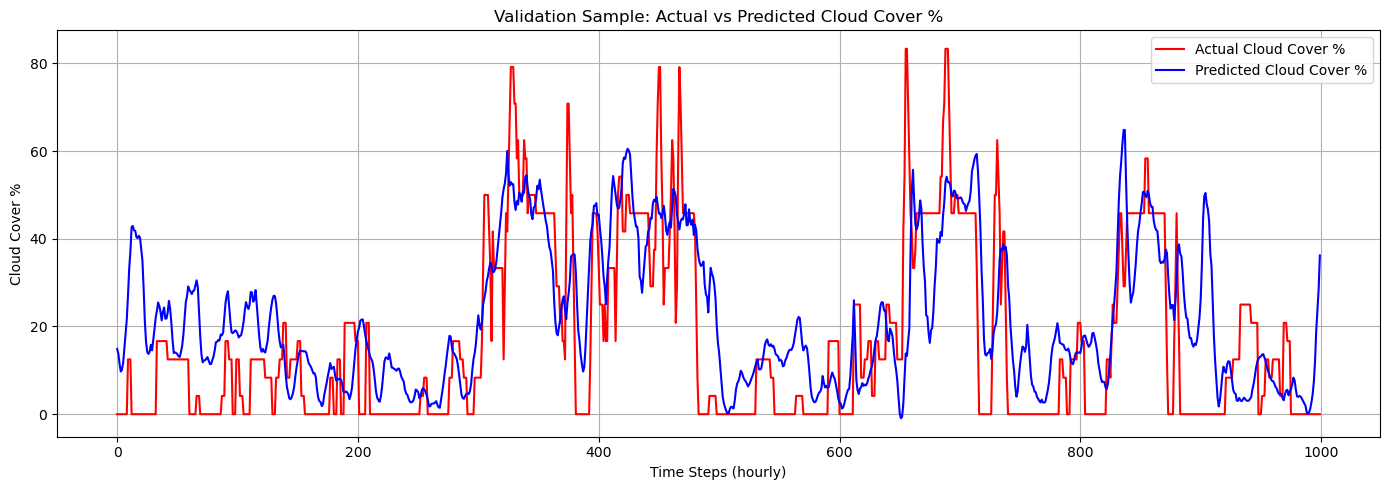

In [90]:
val_preds_scaled = lstm_model2.predict(X_val)

# --- Inverse transform (convert back to original cloud cover scale) ---
val_preds = scaler.inverse_transform(np.concatenate([val_preds_scaled], axis=1))
val_actual = scaler.inverse_transform(np.concatenate([y_val], axis=1))

# --- Plot: Actual vs Predicted on Validation Sample ---
sample_size = 1000  # change to 1000, etc., for longer comparison

plt.figure(figsize=(14, 5))
plt.plot(val_actual[:sample_size], label='Actual Cloud Cover %', color='red')
plt.plot(val_preds[:sample_size], label='Predicted Cloud Cover %', color='blue')
plt.title("Validation Sample: Actual vs Predicted Cloud Cover %")
plt.xlabel("Time Steps (hourly)")
plt.ylabel("Cloud Cover %")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()